# Imports and paths

In [1]:
import xarray as xr
import netCDF4 as ncdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import scipy.stats as ss
import scipy.interpolate as si
rng = np.random.default_rng(42)

In [2]:
%cd ..

/home/cdauvill/inria/tc_probabilistic_forecasting


In [3]:
with open("config.yml", 'r') as cfg_file:
    cfg = yaml.safe_load(cfg_file)
_TCIR_INFO_PATH_ = cfg['paths']['tcir_info_preprocessed']

# Loading

In [4]:
tcir_info = pd.read_csv(_TCIR_INFO_PATH_)
tcir_info.head()

,level_0,index,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP
0,0,0,ATLN,200301L_0,-66.2,29.1,2003-04-18 00:00:00,30.0,0.0,1008.0
1,1,2,ATLN,200301L_0,-66.0,29.9,2003-04-18 06:00:00,30.0,0.0,1008.0
2,2,4,ATLN,200301L_0,-65.8,30.8,2003-04-18 12:00:00,30.0,0.0,1008.0
3,3,6,ATLN,200301L_0,-66.3,31.9,2003-04-18 18:00:00,30.0,0.0,1007.0
4,4,8,ATLN,200301L_0,-66.9,33.0,2003-04-19 00:00:00,30.0,0.0,1007.0


# Intensity distribution

## General distribution
Let's first look at the distribution of the intensity overall:

<Axes: xlabel='INTENSITY', ylabel='Count'>

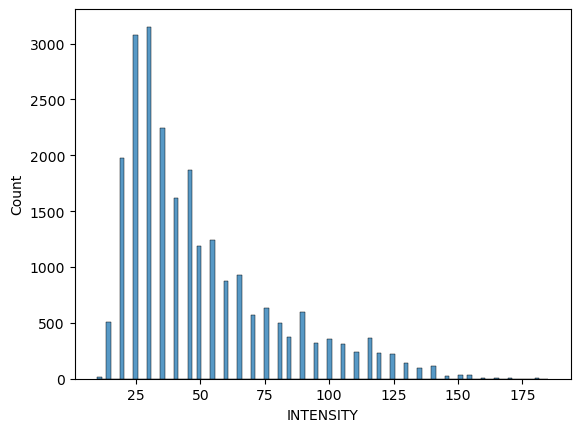

In [5]:
sns.histplot(tcir_info, x='INTENSITY', bins=100)

## Fitting distributions

In [6]:
def test_distrib(dist_names, dist_classes, samples):
    """
    Fits distributions from a set of given classes to the intensity samples.
    Performs KS tests to evaluate the fits, and plots the pdf & cdf.
    """
    ecdf = ss.ecdf(samples)
    fig, axes = plt.subplots(nrows=2, ncols=len(dist_names), squeeze=False,
                            tight_layout=True, figsize=(3*len(dist_names), 6))
    for k, (dist_name, dist_class) in enumerate(zip(dist_names, dist_classes)):
        params = dist_class.fit(samples)
        # KS test
        ksres = ss.kstest(samples, dist_name, params)
        print("KS p-value: ", ksres.pvalue)
    
        # Plot the PDF versus the data histogram
        x = np.linspace(0, 190, 100)
        axes[0, k].plot(x, dist_class.pdf(x, *params))
        axes[0, k].hist(samples, density=True, bins=20)

        # Plot the CDF versus the eCDF
        axes[1, k].plot(x, dist_class.cdf(x, *params))
        ecdf.cdf.plot(axes[1, k])

        axes[1, k].set_title(f'{dist_name} - p={ksres.pvalue:.2E}')
    plt.show()

KS p-value:  3.194468193775554e-238
KS p-value:  7.47514293743488e-174
KS p-value:  3.3926299361771093e-144
KS p-value:  0.0
KS p-value:  9.743483254058593e-176


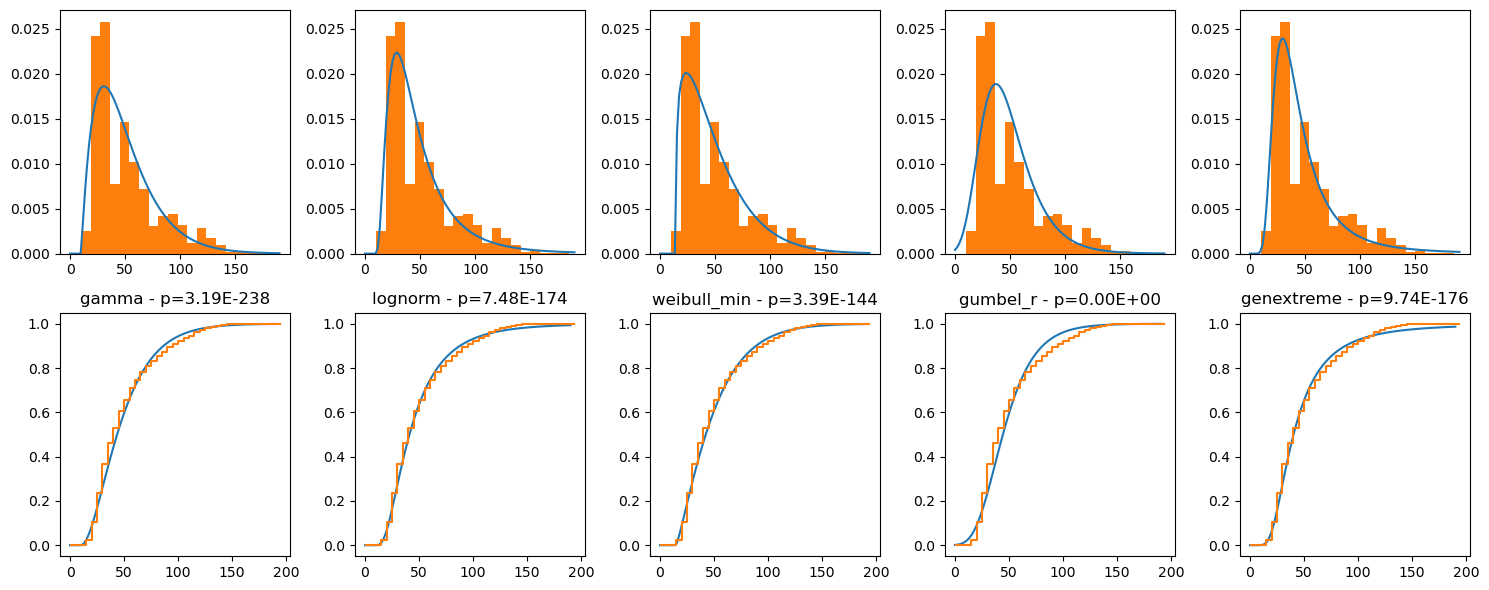

In [7]:
dist_names = ['gamma', 'lognorm', 'weibull_min', 'gumbel_r', 'genextreme']
dist_classes = [ss.gamma, ss.lognorm, ss.weibull_min, ss.gumbel_r, ss.genextreme]
test_distrib(dist_names, dist_classes, tcir_info['INTENSITY'])

The Kolmogorov-Smirnov statistic is based on the maximum distance between the empirical CDF and the the CDF of the tested distribution. Since our empirical distribution is actually discrete, its CDF makes big jumps. This means the distance between the empirical CDF and the fitted distribution is large just before each jump, flawing the KS statistic.

<Axes: xlabel='INTENSITY'>

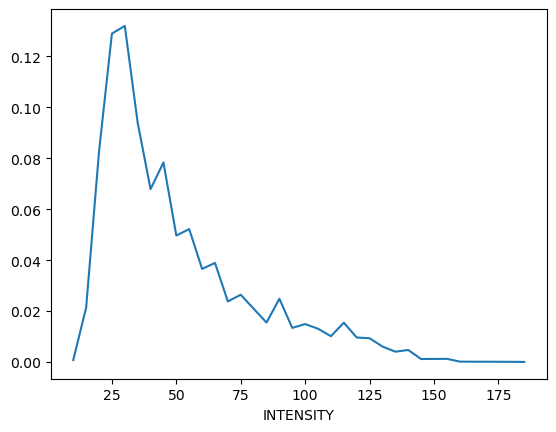

In [8]:
epdf = tcir_info['INTENSITY'].value_counts().sort_index()
epdf = epdf / epdf.sum()
epdf.plot()

### Adding noise to the discrete values
Since the recorded intensities in IBTrACS are actually discrete, we'll add noise to turn them into a continous distribution (which is of course the case for the real intensities). We'll use gaussian noise centered on the recorded values. Since the uncertainty estimates in IBTrACS is +/- 10kts for storms after 2000, we'll use a standard deviation of 3kts, which is absolutely arbitrary but somewhat respects the little information we have from IBTrACS.

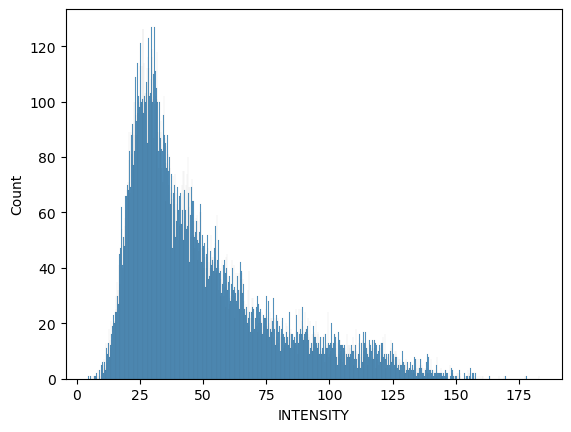

In [10]:
noised_ws = tcir_info['INTENSITY'] + rng.normal(0, 3, tcir_info['INTENSITY'].shape)
sns.histplot(x=noised_ws, bins=1000)
plt.show()

KS p-value:  3.3071226782136203e-96
KS p-value:  2.3670750511168894e-29
KS p-value:  1.7034653721091976e-135
KS p-value:  2.1043988496165633e-21
KS p-value:  9.834328471567684e-21


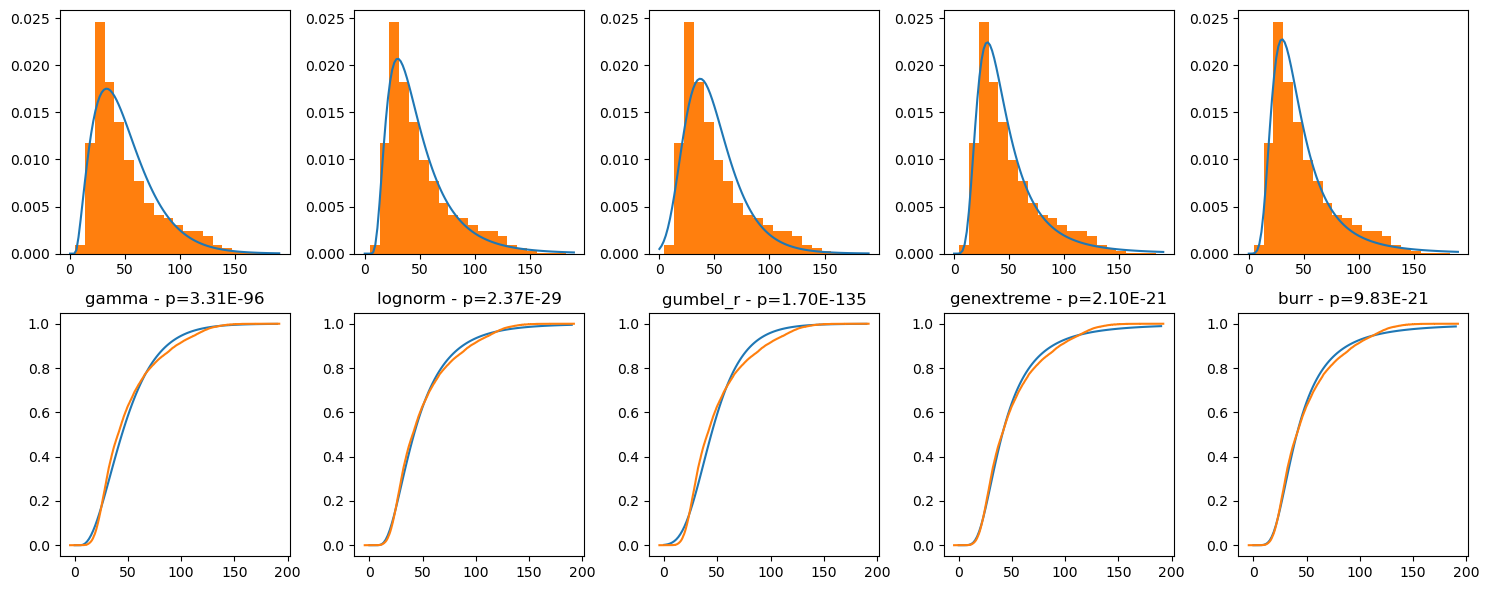

In [11]:
dist_names = ['gamma', 'lognorm', 'gumbel_r', 'genextreme', 'burr']
dist_classes = [ss.gamma, ss.lognorm, ss.gumbel_r, ss.genextreme, ss.burr]
test_distrib(dist_names, dist_classes, noised_ws)

In [12]:
for dist_name in ['gumbel_r', 'weibull_min']:
    res = ss.anderson(noised_ws, dist_name)
    print(f'{dist_name} : ')
    print(res, '\n')

gumbel_r : 
AndersonResult(statistic=341.5581099582887, critical_values=array([0.473, 0.636, 0.756, 0.876, 1.037]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=37.06463667398236, scale=19.8093688387321)
 success: True
 message: '`anderson` successfully fit the distribution to the data.') 

weibull_min : 
AndersonResult(statistic=332.065135422803, critical_values=array([0.342, 0.472, 0.563, 0.636, 0.758, 0.88 , 1.043, 1.168]), significance_level=array([0.5  , 0.75 , 0.85 , 0.9  , 0.95 , 0.975, 0.99 , 0.995]), fit_result=  params: FitParams(c=1.6724819163375995, loc=4.572931153899419, scale=50.86784937768795)
 success: True
 message: '`anderson` successfully fit the distribution to the data.') 



## Temporal conditional distributions

Let's now look at the distribution of the *next* intensity, i.e. $P(Y_t|Y_{t-1})$:

In [34]:
tcir_info['NEXT_INTENSITY'] = tcir_info.groupby('SID')['INTENSITY'].shift(-1)
tcir_info['DELTA_INTENSITY'] = (tcir_info['NEXT_INTENSITY'] - tcir_info['INTENSITY'])
tcir_info.head(10)

,level_0,index,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP,NEXT_INTENSITY,DELTA_INTENSITY
0,0,0,ATLN,200301L_0,-66.2,29.1,2003-04-18 00:00:00,30.0,0.0,1008.0,30.0,0.0
1,1,2,ATLN,200301L_0,-66.0,29.9,2003-04-18 06:00:00,30.0,0.0,1008.0,30.0,0.0
2,2,4,ATLN,200301L_0,-65.8,30.8,2003-04-18 12:00:00,30.0,0.0,1008.0,30.0,0.0
3,3,6,ATLN,200301L_0,-66.3,31.9,2003-04-18 18:00:00,30.0,0.0,1007.0,30.0,0.0
4,4,8,ATLN,200301L_0,-66.9,33.0,2003-04-19 00:00:00,30.0,0.0,1007.0,35.0,5.0
5,5,10,ATLN,200301L_0,-67.6,33.8,2003-04-19 06:00:00,35.0,0.0,1006.0,35.0,0.0
6,6,12,ATLN,200301L_0,-68.6,34.5,2003-04-19 12:00:00,35.0,0.0,1006.0,35.0,0.0
7,7,14,ATLN,200301L_0,-69.1,34.3,2003-04-19 18:00:00,35.0,0.0,1006.0,40.0,5.0
8,8,16,ATLN,200301L_0,-69.0,33.6,2003-04-20 00:00:00,40.0,0.0,1005.0,40.0,0.0
9,9,18,ATLN,200301L_0,-68.9,32.7,2003-04-20 06:00:00,40.0,0.0,1003.0,45.0,5.0


<Axes: xlabel='DELTA_INTENSITY', ylabel='Count'>

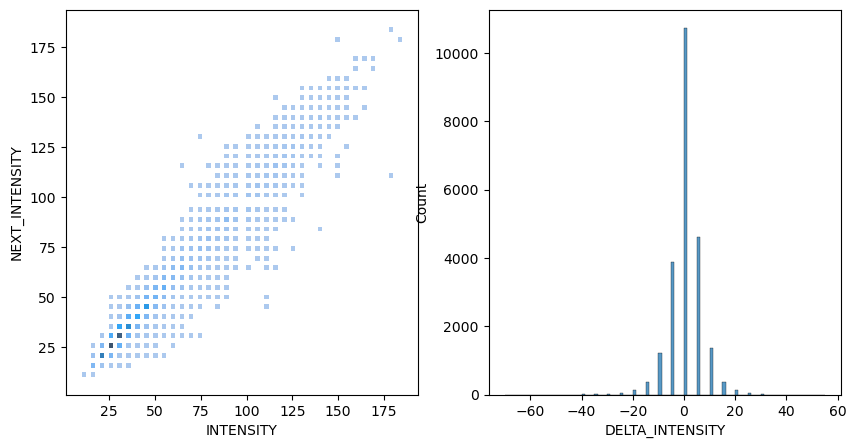

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(tcir_info, x='INTENSITY', y='NEXT_INTENSITY', ax=axes[0])
sns.histplot(tcir_info, x='DELTA_INTENSITY', ax=axes[1], bins=100)

Let's statistically test for normality:

In [38]:
ntest_res = ss.normaltest(tcir_info['DELTA_INTENSITY'].dropna().values)
ntest_res

NormaltestResult(statistic=3843.6336433468477, pvalue=0.0)

Hence we can reject the hypothesis that $P(Y_{t+1}|Y_t)$ is a normal distribution.

One could wonder: is the evolution of the intensity over more than two timesteps a multivariate gaussian ?

In [53]:
vmax_evol_df = tcir_info[['SID', 'ISO_TIME', 'INTENSITY']].copy()
for i in range(1, 9):
    vmax_evol_df[f'INTENSITY_+{i}'] = vmax_evol_df.groupby('SID')['INTENSITY'].shift(-i)
    vmax_evol_df[f'DELTA_INTENSITY_+{i}'] = vmax_evol_df[f'INTENSITY_+{i}'] - vmax_evol_df['INTENSITY']
vmax_evol_df = vmax_evol_df.dropna(axis='rows')

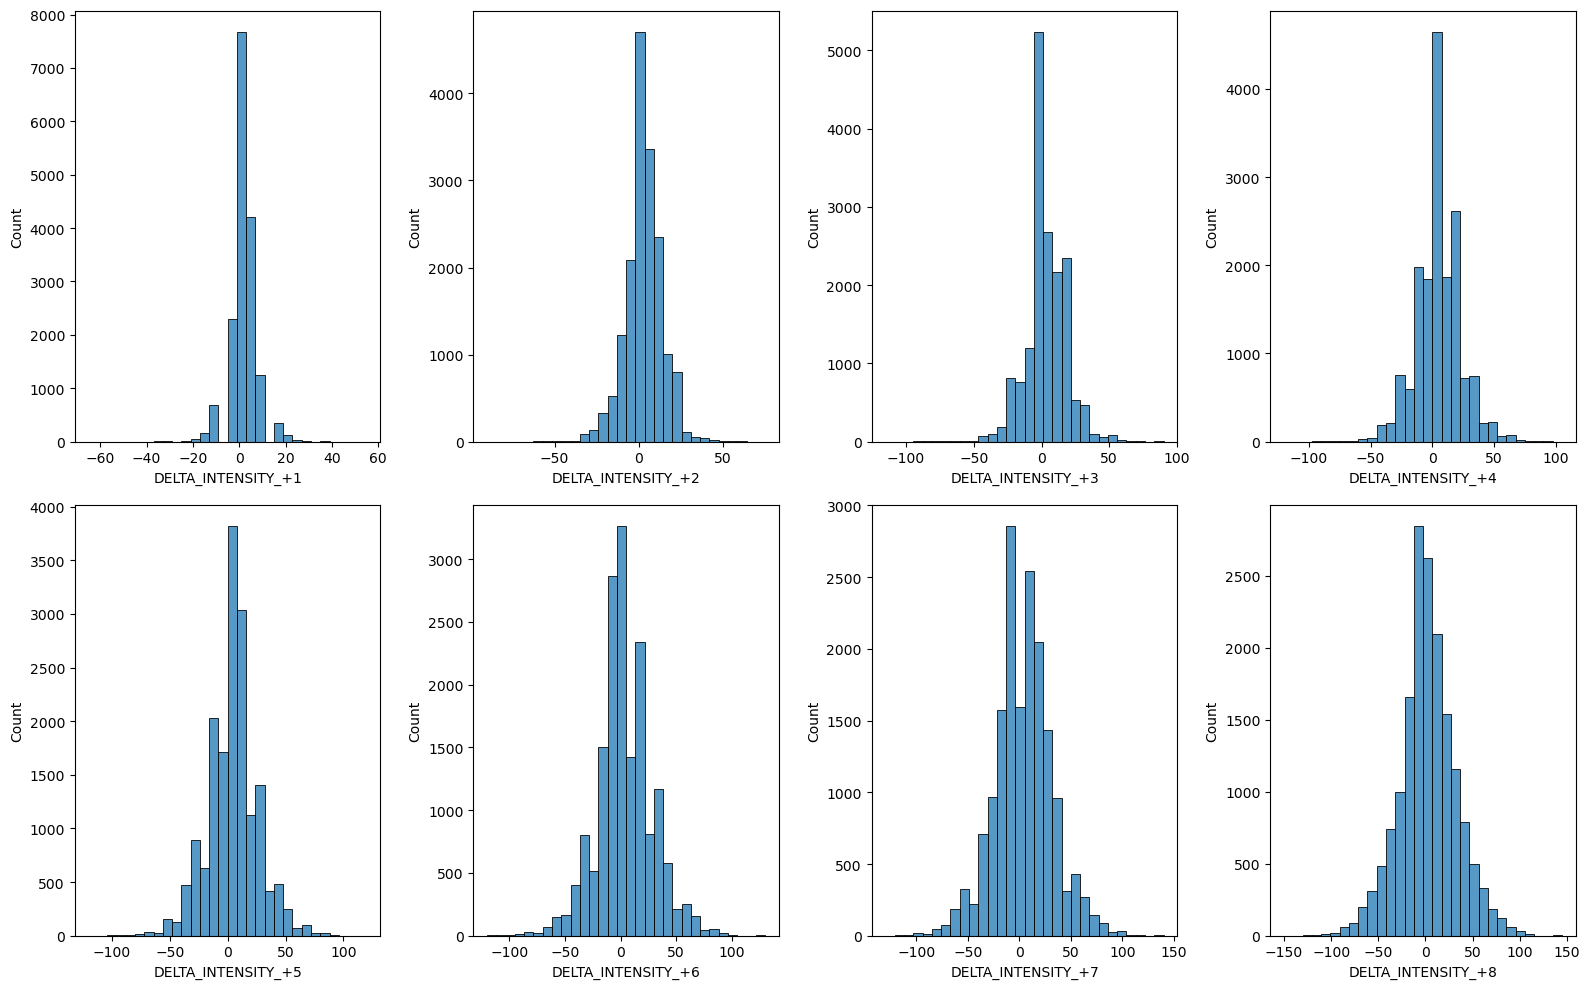

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    sns.histplot(vmax_evol_df, x=f'DELTA_INTENSITY_+{i+1}', ax=ax, bins=30)